# Clasificador Bayesiano con Basic Count y con TF-IDF

# 1 Preparación del entorno
Importación de las librerías necesarias para la ejecución del cuaderno.

**OBSERVACIÓN**: Incluye la librería de lematización de spacy. Esta librería requiere tener descargado el modelo de lematización previo a ser usado. Si no lo tienes descargado en tu entorno fallará.
Recuerda que para descargarlo deberás utilizar alguna de las instrucciones siguientes desde tu entorno Python dependiendo del modelo de lematización que quieras utilizar:
- `python -m spacy download es_core_news_sm`
- `python -m spacy download es_core_news_md`

In [1]:
from collections import Counter
import string
import re

import pandas as pd
import numpy as np

# Descargamos los recursos necesarios de NLTK si es que no existen previamente en el entorno.
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)

try:
    nltk.data.find("tokenizers/punkt_tab")
except LookupError:
    nltk.download("punkt_tab", quiet=True)

try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

# Módulos necesarios de NLTK que utilizaremos para el preprocesamiento de la información.
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Lematización
# Para que funcione la carga del modelo de lematización este tiene que estar descargado en el entorno primeramente.
# Para ello se puede utilizar alguna de las instrucciones siguientes desde tu entorno Python dependiendo del modelo de lematización que quieras utilizar:
# python -m spacy download es_core_news_sm (modelo pequeño)
# python -m spacy download es_core_news_md (modelo mediano)
import spacy
nlp = spacy.load("es_core_news_sm")
# nlp = spacy.load("es_core_news_md")

# Stemming
from nltk.stem import SnowballStemmer

# Módulos necesarios de la librería Scikit-Learn que vamos a utilizar para a construcción del modelo TF-IDF.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

# Representaciones gráficas varias ...
import matplotlib.pyplot as plt
import seaborn as sns

# Persistencia de modelos
import joblib

# 2 Preparación del DataSet

## 2.1 Dataset de entrenamiento
Conjunto de datos utilizado para el entrenamiento de nuestros diferentes modelos.

In [2]:
TRAIN_DATASET = [
    "Gana dinero rápido, con premio gratis y sorteo ganador",
    "Oferta especial con premio y dinero fácil gratis",
    "Ganador de un sorteo con millones gratis. Haz clic",
    "Reunión por la mañana para proyecto. Informe equipo",
    "Informe para proyecto. Reunión equipo trabajo",
    "Trabajo para el equipo de documentación. Reunión mañana",
]

TRAIN_DATASET_LABELS = ["SPAM", "SPAM", "SPAM", "LEGITIMO", "LEGITIMO", "LEGITIMO"]

## 2.2 Dataset de pruebas
Conjunto de documentos utilizados para la evaluación de nuestros modelos.

In [3]:
TEST_DATASET = [
    "premio gratis ganador dinero",
    "reunión equipo proyecto mañana",
    "oferta trabajo equipo proyecto especial"
]

TEST_DATASET_LABELS = ["SPAM", "LEGITIMO", "SPAM"]

# 3. Función de procesamiento
Esta es la función que utilizaremos tanto para pre-procesar los documentos de entrenamiento como los de test.

In [4]:
def preprocesar_documento(documento):
    """
    Función para preprocesar un documento individual
    
    Args:
        documento (str): Texto del documento a preprocesar
    
    Returns:
        list: Lista de tokens normalizados para el texto a preprocesar.
    """
    # Convertir a minúsculas
    documento = documento.lower()
    
    # Eliminar signos de puntuación usando expresiones regulares
    # documento = re.sub(r'[^\w\s]', '', documento)
    
    # Tokenizar usando NLTK
    tokens = word_tokenize(documento, language='spanish')

    # Eliminación de puntuación y stopwords
    stop_words = set(stopwords.words("spanish"))
    tokens_limpios = [t for t in tokens if t not in string.punctuation and t not in stop_words]
    
    # Filtrar tokens que no sean alfabéticos (eliminar números)
    tokens_filtrados = [token for token in tokens_limpios if token.isalpha()]

    # Lamtización usando spaCy
    doc_spacy = nlp(" ".join(tokens_filtrados))
    tokens_lemmatizados = [token.lemma_ for token in doc_spacy] 
    
    return tokens_lemmatizados

# Aplicamos el preprocesamiento a todos los documentos
documentos_procesados = []
for i, doc in enumerate(TRAIN_DATASET):
    tokens = preprocesar_documento(doc)
    documentos_procesados.append(tokens)
    if i < 3:  # Mostramos los primeros 3 documentos como ejemplo
        # print(f"Documento {i+1} procesado: {tokens[:10]}...")  # Primeras 10 palabras
        print(f"Documento {i+1} procesado: {tokens}...")  # Primeras 10 palabras

# Unir los tokens de cada documento en una cadena
documentos_procesados_texto = [" ".join(tokens) for tokens in documentos_procesados]
print(f"Documentos procesados: {documentos_procesados_texto}")

Documento 1 procesado: ['ganar', 'dinero', 'rápido', 'premio', 'gratis', 'sorteo', 'ganador']...
Documento 2 procesado: ['oferta', 'especial', 'premio', 'dinero', 'fácil', 'gratis']...
Documento 3 procesado: ['ganador', 'sorteo', 'millón', 'gratis', 'haz', 'clic']...
Documentos procesados: ['ganar dinero rápido premio gratis sorteo ganador', 'oferta especial premio dinero fácil gratis', 'ganador sorteo millón gratis haz clic', 'reunión mañana proyecto informe equipo', 'informir proyecto reunión equipo trabajar', 'trabajo equipo documentación reunión mañana']


# 4. Entrenamiento de Clasificadores Multinomiales NB

Vamos a entrenar dos modelos diferentes dependiendo de cómo calculemos $P(w_i | clase)$:

1. Utilizando un conteo básico
2. Utilizando TF-IDF

## 4.1 Calisificador Multinomial NB por conteo de palabras

### 4.1.1 Creación y configuración del vectorizador por conteo + vectorizado

Utilizaremos la clase `CountVectorizer` de sklearn para ello. Más información [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

A continuación una explicación de los parámetros utilizados:

- `stop_words=None`: No se eliminan palabras vacías adicionales (ya se eliminaron en el preprocesamiento).

- `ngram_range=(1,1)`: Se utilizan unigramas (palabras individuales).

- `analyzer='word'`: El análisis se realiza a nivel de palabras (opciones: 'word', 'char', 'char_wb')
                 'word', 'char': Indica si los n-gramas se generarán por palabras o caracteres respectivamente.
                 'char_wb': Indica si la característica debe estar compuesta por n-gramas de caracteres dentro de los límites de las palabras;
                            los n-gramas en los bordes de las palabras se rellenan con espacios.

- `max_df=0.5`: Controla cómo deben ser de comunes las palabras para incluirlas en el vocabulario.
            Si una palabra aparece en demasiados documentos se considera poco informativa.
            Por defecto, el parámetro max_df puede recibir:
                 - Un número flotante: Hace referencia al porcentaje de documentos a incluir. Por ejemplo, max_df= 0.5 ignorará las palabras que aparecen en más del 50% de los documentos.
                 - Un número entero: Realizará un conteo absoluto a la hora de incluir documentos. Por ejemplo, max_df= 5 ignorará las palabras que aparecen en más de 5 documentos.

- `min_df=1`: Se incluyen todas las palabras que aparecen al menos en 1 documento.

- `max_features=None`: No se limita el número de características (todas las palabras se incluyen). Si se estableciera un valor, se seleccionarían las palabras más frecuentes hasta ese número.

In [5]:
# Crear el vectorizador por conteo.
vectorizer_count = CountVectorizer(
    stop_words=None,
    ngram_range=(1,1),
    analyzer='word',
    max_df=0.5,
    min_df=1,
    max_features=None
)

X_train_counts = vectorizer_count.fit_transform(raw_documents=documentos_procesados_texto) # Vectorización por conteo.

# Muestra el tamaño de la matriz de conteo de frecuencias
print("Tamaño de la matriz de conteo de frecuencias:", X_train_counts.shape)
# Muestra algunas características del vectorizador por conteo de frecuencias
print("Número de características (palabras únicas) en el vocabulario:", len(vectorizer_count.vocabulary_))
print("Características (primeras 10 palabras):", list(vectorizer_count.vocabulary_.keys()))

Tamaño de la matriz de conteo de frecuencias: (6, 22)
Número de características (palabras únicas) en el vocabulario: 22
Características (primeras 10 palabras): ['ganar', 'dinero', 'rápido', 'premio', 'gratis', 'sorteo', 'ganador', 'oferta', 'especial', 'fácil', 'millón', 'haz', 'clic', 'reunión', 'mañana', 'proyecto', 'informe', 'equipo', 'informir', 'trabajar', 'trabajo', 'documentación']


### 4.1.2 Entrenamiento del Modelo de Clasificación NB por conteo

Utilizaremos la clase `MultinomialNB' de sklearn para ello. Más información [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

A continuación una explicación de los hiper-parámetros utilizados en el entrenamiento:

- `alpha=1.0`: Parámetro de suavizado de Laplace. Ayuda a manejar palabras que no aparecen en el conjunto de entrenamiento.

- `force_alpha=`True: Fuerza el uso del parámetro alpha para el suavizado. Si False, entonces usa alfa= 1e-10.

- `fit_prior=True`: Indica que se deben aprender las probabilidades a priori de las clases a partir de los datos ($P(clase)$).

- `class_prior`=None: No se especifican probabilidades a priori personalizadas; se calculan automáticamente.

In [6]:
# Creamos el clasificador Multinomial NB y configuramos sus hiper-parámetros
clf_count = MultinomialNB (
    alpha= 1.0,
    force_alpha= True,
    fit_prior= True, 
    class_prior= None,
)

# Entrenamiento del clasificador y medición del tiempo de entrenamiento
start_time = pd.Timestamp.now()
clf_count.fit(X_train_counts,TRAIN_DATASET_LABELS)
end_time = pd.Timestamp.now()
training_time = (end_time - start_time).total_seconds()

print(f"Tiempo de entrenamiento del clasificador: {training_time} segundos")

# Muestra aspectos del modelo entrenado
print("Características (primeras 10 palabras):", list(vectorizer_count.vocabulary_.keys())[:10])
print("Clases del modelo:", clf_count.classes_)
# Muestra top frecuencias
feature_counts = np.asarray(X_train_counts.sum(axis=0)).flatten()
feature_names = vectorizer_count.get_feature_names_out()
feature_freq = list(zip(feature_names, feature_counts))
feature_freq.sort(key=lambda x: x[1], reverse=True)
print("Top 10 palabras más frecuentes")
print("------------------------------")
for word, freq in feature_freq[:10]:
    print(f"{word}: {freq}")
print("Top 10 palabras menos frecuentes")
print("------------------------------")
for word, freq in feature_freq[-10:]:
    print(f"{word}: {freq}")

Tiempo de entrenamiento del clasificador: 0.0 segundos
Características (primeras 10 palabras): ['ganar', 'dinero', 'rápido', 'premio', 'gratis', 'sorteo', 'ganador', 'oferta', 'especial', 'fácil']
Clases del modelo: ['LEGITIMO' 'SPAM']
Top 10 palabras más frecuentes
------------------------------
equipo: 3
gratis: 3
reunión: 3
dinero: 2
ganador: 2
mañana: 2
premio: 2
proyecto: 2
sorteo: 2
clic: 1
Top 10 palabras menos frecuentes
------------------------------
fácil: 1
ganar: 1
haz: 1
informe: 1
informir: 1
millón: 1
oferta: 1
rápido: 1
trabajar: 1
trabajo: 1


### 4.1.3 Guardado del modelo

Utilizamos la librería `joblib` para guardar el modelo que se ha generado y poder utilizarlo posteriormente.

- Para guardar un modelo: `joblib.dump(<modelo>, <fichero_modelo>)`

- Para cargar un modelo: 'modelo= joblib.load(<fichero_modelo>)`


## 4.2 Entrenamiento Clasificador Multinomial NB con TF-IDF

### 4.2.1 Creación y configuración del vectorizador por TF-IDF + vectorizado

Utilizaremos la clase `TfidfVectorizer` de sklearn para ello. Más información [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

A continuación una explicación de los parámetros utilizados:

- `stop_words=None`: No se eliminan palabras vacías adicionales (ya se eliminaron en el preprocesamiento).

- `ngram_range=(1,1)`: Se utilizan unigramas (palabras individuales).

- `analyzer='word'`: El análisis se realiza a nivel de palabras (opciones: 'word', 'char', 'char_wb')
                 'word', 'char': Indica si los n-gramas se generarán por palabras o caracteres respectivamente.
                 'char_wb': Indica si la característica debe estar compuesta por n-gramas de caracteres dentro de los límites de las palabras;
                            los n-gramas en los bordes de las palabras se rellenan con espacios.

- `max_df=0.5`: Controla cómo deben ser de comunes las palabras para incluirlas en el vocabulario.
            Si una palabra aparece en demasiados documentos se considera poco informativa.
            Por defecto, el parámetro max_df puede recibir:
                 - Un número flotante: Hace referencia al porcentaje de documentos a incluir. Por ejemplo, max_df= 0.5 ignorará las palabras que aparecen en más del 50% de los documentos.
                 - Un número entero: Realizará un conteo absoluto a la hora de incluir documentos. Por ejemplo, max_df= 5 ignorará las palabras que aparecen en más de 5 documentos.

- `min_df=1`: Se incluyen todas las palabras que aparecen al menos en 1 documento.

- `max_features=None`: No se limita el número de características (todas las palabras se incluyen). Si se estableciera un valor, se seleccionarían las palabras más frecuentes hasta ese número.

In [7]:
# Crea el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer (
    stop_words=None, 
    ngram_range= (1,1),
    analyzer='word',
    max_df=0.5,
    min_df=1,
    max_features= None
)

X_train_tfidf = tfidf_vectorizer.fit_transform(raw_documents=documentos_procesados_texto)   # Vectorización TF-IDF

# Muestra el tamaño de la matriz TF-IDF
print("Tamaño de la matriz TF-IDF:", X_train_tfidf.shape)
# Muestra algunas características del vectorizador TF-IDF
print("Número de características (palabras únicas) en el vocabulario TF-IDF:", len(tfidf_vectorizer.vocabulary_))
print("Características (primeras 10 palabras TF-IDF):", list(tfidf_vectorizer.vocabulary_.keys())[:10])

Tamaño de la matriz TF-IDF: (6, 22)
Número de características (palabras únicas) en el vocabulario TF-IDF: 22
Características (primeras 10 palabras TF-IDF): ['ganar', 'dinero', 'rápido', 'premio', 'gratis', 'sorteo', 'ganador', 'oferta', 'especial', 'fácil']


### 4.2.2 Entrenamiento del Modelo de Clasificación NB con TF-IDF

In [8]:
# Creamos el clasificador Multinomial NB y configuramos sus hiper-parámetros
clf_tfidf = MultinomialNB (
    alpha= 1.0,
    force_alpha= True,
    fit_prior= True, 
    class_prior= None,
)

# Entrenamiento del clasificador y medición del tiempo de entrenamiento
start_time = pd.Timestamp.now()
clf_tfidf.fit(X_train_tfidf, TRAIN_DATASET_LABELS)
end_time = pd.Timestamp.now()
training_time = (end_time - start_time).total_seconds()

print(f"Tiempo de entrenamiento del clasificador: {training_time} segundos")

# Muestra aspectos del modelo entrenado
print("Características (primeras 10 palabras TF-IDF):", list(tfidf_vectorizer.vocabulary_.keys())[:10])
print("Clases del modelo TF-IDF:", clf_tfidf.classes_)
# Muestra top frecuencias
feature_counts = np.asarray(X_train_tfidf.sum(axis=0)).flatten()
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_freq = list(zip(feature_names, feature_counts))
feature_freq.sort(key=lambda x: x[1], reverse=True)
print("Top 10 palabras más frecuentes")
print("------------------------------")
for word, freq in feature_freq[:10]:
    print(f"{word}: {freq}")
print("Top 10 palabras menos frecuentes")
print("------------------------------")
for word, freq in feature_freq[-10:]:
    print(f"{word}: {freq}")

Tiempo de entrenamiento del clasificador: 0.0 segundos
Características (primeras 10 palabras TF-IDF): ['ganar', 'dinero', 'rápido', 'premio', 'gratis', 'sorteo', 'ganador', 'oferta', 'especial', 'fácil']
Clases del modelo TF-IDF: ['LEGITIMO' 'SPAM']
Top 10 palabras más frecuentes
------------------------------
equipo: 1.1075448132983108
reunión: 1.1075448132983108
gratis: 0.9349168253686694
mañana: 0.8815035777509508
proyecto: 0.8815035777509508
dinero: 0.7340229458804547
ganador: 0.7340229458804547
premio: 0.7340229458804547
sorteo: 0.7340229458804547
informe: 0.5501951970149236
Top 10 palabras menos frecuentes
------------------------------
trabajar: 0.5247904125809654
trabajo: 0.5247904125809654
clic: 0.45529186966597734
especial: 0.45529186966597734
fácil: 0.45529186966597734
haz: 0.45529186966597734
millón: 0.45529186966597734
oferta: 0.45529186966597734
ganar: 0.43984244839075914
rápido: 0.43984244839075914


# 5. Fase de pruebas

## Pruebas Clasificador NB (por Conteo)

In [9]:
y_pred_list = []  # Lista para almacenar las predicciones

for i, test_doc in enumerate(TEST_DATASET):
    # Preprocesar el documento de prueba
    tokens_test = preprocesar_documento(test_doc)
    doc_test_procesado = " ".join(tokens_test)
    
    # Vectorizar el documento de prueba
    X_test_count = vectorizer_count.transform([doc_test_procesado])
    
    # Realizar la predicción
    y_pred = clf_count.predict(X_test_count)
    y_pred_list.append(y_pred[0])  # Append the prediction to the list
    
    # Comparar con la etiqueta real
    etiqueta_real = TEST_DATASET_LABELS[i]
    es_correcto = (y_pred[0] == etiqueta_real)
    # accuracy_scores.apçpend(es_correcto)
    
    print(f"Documento de prueba {i+1}: '{test_doc}'")
    print(f"Tokens procesados: {tokens_test}")
    print(f"Predicción: {y_pred[0]}, Etiqueta real: {etiqueta_real}, Correcto: {es_correcto}\n")

Documento de prueba 1: 'premio gratis ganador dinero'
Tokens procesados: ['premio', 'gratis', 'ganador', 'dinero']
Predicción: SPAM, Etiqueta real: SPAM, Correcto: True

Documento de prueba 2: 'reunión equipo proyecto mañana'
Tokens procesados: ['reunión', 'equipo', 'proyecto', 'mañana']
Predicción: LEGITIMO, Etiqueta real: LEGITIMO, Correcto: True

Documento de prueba 3: 'oferta trabajo equipo proyecto especial'
Tokens procesados: ['oferta', 'trabajo', 'equipo', 'proyecto', 'especial']
Predicción: LEGITIMO, Etiqueta real: SPAM, Correcto: False



### Matriz de Confusión - Clasificador NB (por Conteo)

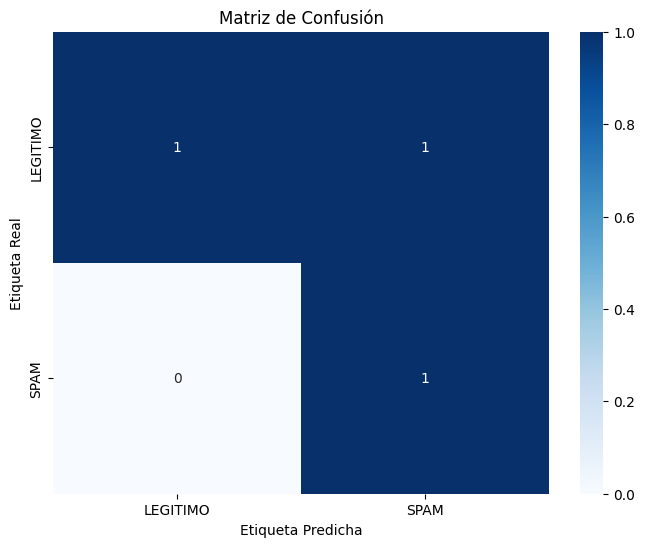

In [10]:
# MATRIZ DE CONFUSIÓN
confusion_mat = confusion_matrix(TEST_DATASET_LABELS, y_pred_list)

# Visualizar la matriz de confusión usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat.T, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(set(TRAIN_DATASET_LABELS)),
            yticklabels=list(set(TRAIN_DATASET_LABELS)))
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()


### Exactitud General - Clasificador NB (por Conteo)

In [11]:
accuracy = accuracy_score(TEST_DATASET_LABELS, y_pred_list)
print(f"EXACTITUD GLOBAB (Overall Accuracy)= {accuracy} (Clasificador NB por conteo)")

EXACTITUD GLOBAB (Overall Accuracy)= 0.6666666666666666 (Clasificador NB por conteo)


### Métricas por clase - Clasificador NB (por Conteo)

In [12]:
precision = precision_score(TEST_DATASET_LABELS, y_pred_list, average=None, labels=list(set(TEST_DATASET_LABELS)))
recall = recall_score(TEST_DATASET_LABELS, y_pred_list, average=None, labels=list(set(TEST_DATASET_LABELS)))
f1 = f1_score(TEST_DATASET_LABELS, y_pred_list, average=None, labels=list(set(TEST_DATASET_LABELS)))

print(f"MÉTRICAS POR CLASE (Clasificador NB por conteo)")
print("===============================================\n")
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1-score per class: {f1}")

MÉTRICAS POR CLASE (Clasificador NB por conteo)

Precision per class: [0.5 1. ]
Recall per class: [1.  0.5]
F1-score per class: [0.66666667 0.66666667]


### Métricas Agrupadas - Clasificador NB (por Conteo)

In [13]:
precision_averaged_macro = precision_score(TEST_DATASET_LABELS, y_pred_list, average='macro')
recall_avegraged_macro = recall_score(TEST_DATASET_LABELS, y_pred_list, average='macro')
f1_averaged_macro = f1_score(TEST_DATASET_LABELS, y_pred_list, average='macro')

precision_averaged_micro = precision_score(TEST_DATASET_LABELS, y_pred_list, average='micro')
recall_avegraged_micro = recall_score(TEST_DATASET_LABELS, y_pred_list, average='micro')
f1_averaged_micro = f1_score(TEST_DATASET_LABELS, y_pred_list, average='micro')

precision_averaged_wighted = precision_score(TEST_DATASET_LABELS, y_pred_list, average='weighted')
recall_avegraged_weighted = recall_score(TEST_DATASET_LABELS, y_pred_list, average='weighted')
f1_averaged_weighted = f1_score(TEST_DATASET_LABELS, y_pred_list, average='weighted')

print("MÉTRICAS AGRUPADAS (averaged) (Clasificador NB por conteo)")
print("==========================================================\n")
print("Macro Average:")
print("----------------")
print(f"Precision: {precision_averaged_macro}")
print(f"Recall: {recall_avegraged_macro}")
print(f"F1-score: {f1_averaged_macro}")
print("\nMicro Average:")
print("----------------")
print(f"Precision: {precision_averaged_micro}")
print(f"Recall: {recall_avegraged_micro}")
print(f"F1-score: {f1_averaged_micro}")
print("\nWeighted Average:")
print("----------------")
print(f"Precision: {precision_averaged_wighted}")
print(f"Recall: {recall_avegraged_weighted}")
print(f"F1-score: {f1_averaged_weighted}")

MÉTRICAS AGRUPADAS (averaged) (Clasificador NB por conteo)

Macro Average:
----------------
Precision: 0.75
Recall: 0.75
F1-score: 0.6666666666666666

Micro Average:
----------------
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1-score: 0.6666666666666666

Weighted Average:
----------------
Precision: 0.8333333333333334
Recall: 0.6666666666666666
F1-score: 0.6666666666666666


## Pruebas Clasificador NB (con TF-IDF)

In [14]:
tfidf_y_pred_list = []  # Lista para almacenar las predicciones

for i, test_doc in enumerate(TEST_DATASET):
    # Preprocesar el documento de prueba
    tokens_test = preprocesar_documento(test_doc)
    doc_test_procesado = " ".join(tokens_test)
    
    # Vectorizar el documento de prueba
    X_test_count = tfidf_vectorizer.transform([doc_test_procesado])
    
    # Realizar la predicción
    y_pred = clf_count.predict(X_test_count)
    tfidf_y_pred_list.append(y_pred[0])  # Append the prediction to the list
    
    # Comparar con la etiqueta real
    etiqueta_real = TEST_DATASET_LABELS[i]
    es_correcto = (y_pred[0] == etiqueta_real)
    # accuracy_scores.apçpend(es_correcto)
    
    print(f"Documento de prueba {i+1}: '{test_doc}'")
    print(f"Tokens procesados: {tokens_test}")
    print(f"Predicción: {y_pred[0]}, Etiqueta real: {etiqueta_real}, Correcto: {es_correcto}\n")

Documento de prueba 1: 'premio gratis ganador dinero'
Tokens procesados: ['premio', 'gratis', 'ganador', 'dinero']
Predicción: SPAM, Etiqueta real: SPAM, Correcto: True

Documento de prueba 2: 'reunión equipo proyecto mañana'
Tokens procesados: ['reunión', 'equipo', 'proyecto', 'mañana']
Predicción: LEGITIMO, Etiqueta real: LEGITIMO, Correcto: True

Documento de prueba 3: 'oferta trabajo equipo proyecto especial'
Tokens procesados: ['oferta', 'trabajo', 'equipo', 'proyecto', 'especial']
Predicción: LEGITIMO, Etiqueta real: SPAM, Correcto: False



### Matriz de Confusión - Clasificador NB (con TF-IDF)

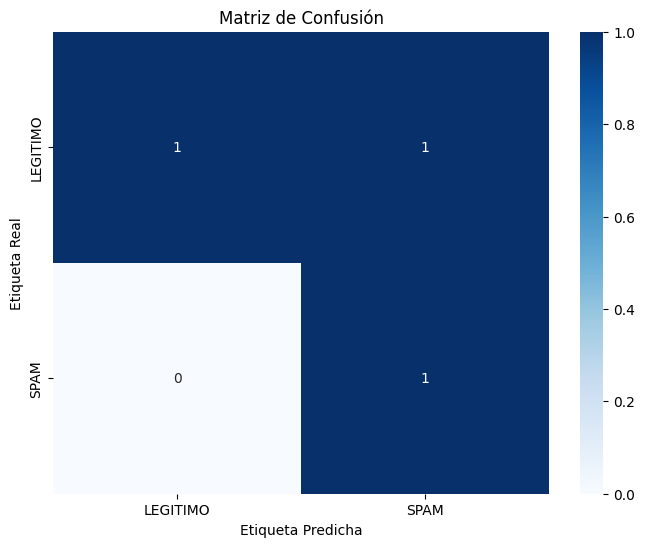

In [15]:
# MATRIZ DE CONFUSIÓN
confusion_mat = confusion_matrix(TEST_DATASET_LABELS, tfidf_y_pred_list)

# Visualizar la matriz de confusión usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat.T, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(set(TRAIN_DATASET_LABELS)),
            yticklabels=list(set(TRAIN_DATASET_LABELS)))
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()


### Exactitud General - Clasificador NB (con TF-IDF)

In [16]:
accuracy = accuracy_score(TEST_DATASET_LABELS, tfidf_y_pred_list)
print(f"EXACTITUD GLOBAB (Overall Accuracy)= {accuracy} (Clasificador NB por TF-IDF)")

EXACTITUD GLOBAB (Overall Accuracy)= 0.6666666666666666 (Clasificador NB por TF-IDF)


### Métricas por clase - Clasificador NB (con TF-IDF)

In [17]:
precision = precision_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average=None, labels=list(set(TEST_DATASET_LABELS)))
recall = recall_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average=None, labels=list(set(TEST_DATASET_LABELS)))
f1 = f1_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average=None, labels=list(set(TEST_DATASET_LABELS)))

print(f"MÉTRICAS POR CLASE (Clasificador NB por conteo)")
print("===============================================\n")
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1-score per class: {f1}")

MÉTRICAS POR CLASE (Clasificador NB por conteo)

Precision per class: [0.5 1. ]
Recall per class: [1.  0.5]
F1-score per class: [0.66666667 0.66666667]


### Métricas Agrupadas - Clasificador NB (con TF-IDF)

In [18]:
# MÉTRICAS AGRUPADAS (averaged)
precision_averaged_macro = precision_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average='macro')
recall_avegraged_macro = recall_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average='macro')
f1_averaged_macro = f1_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average='macro')

precision_averaged_micro = precision_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average='micro')
recall_avegraged_micro = recall_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average='micro')
f1_averaged_micro = f1_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average='micro')

precision_averaged_wighted = precision_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average='weighted')
recall_avegraged_weighted = recall_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average='weighted')
f1_averaged_weighted = f1_score(TEST_DATASET_LABELS, tfidf_y_pred_list, average='weighted')

print("MÉTRICAS AGRUPADAS (averaged) (Clasificador NB por TF-IDF)")
print("==========================================================\n")
print("Macro Average:")
print("----------------")
print(f"Precision: {precision_averaged_macro}")
print(f"Recall: {recall_avegraged_macro}")
print(f"F1-score: {f1_averaged_macro}")
print("\nMicro Average:")
print("----------------")
print(f"Precision: {precision_averaged_micro}")
print(f"Recall: {recall_avegraged_micro}")
print(f"F1-score: {f1_averaged_micro}")
print("\nWeighted Average:")
print("----------------")
print(f"Precision: {precision_averaged_wighted}")
print(f"Recall: {recall_avegraged_weighted}")
print(f"F1-score: {f1_averaged_weighted}")

MÉTRICAS AGRUPADAS (averaged) (Clasificador NB por TF-IDF)

Macro Average:
----------------
Precision: 0.75
Recall: 0.75
F1-score: 0.6666666666666666

Micro Average:
----------------
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1-score: 0.6666666666666666

Weighted Average:
----------------
Precision: 0.8333333333333334
Recall: 0.6666666666666666
F1-score: 0.6666666666666666


# 6. Persistiendo modelos
Podemos guardar los modelos generados para poder volver a utilizarlos cuando deseemos.

A continuación de presentan ejemplos de cómo guardar y cargar los modelos.

In [19]:
MODELO_NB_CONTEO= "model_spam_nb_count.pkl"     # Nombre con el que vamos a guardar el modelo por conteo
MODELO_NB_TFIDF= "model_spam_nb_tfidf.pkl"      # Nombre con el que vamos a guardar el modelo TF-IDF

### 6.1 Guardado de modelos

Utilizamos la librería `joblib` para guardar el modelo que se ha generado y poder utilizarlo posteriormente.

- Para guardar un modelo: `joblib.dump(<modelo>, <fichero_modelo>)`

#### 6.1.1 Guardado y carga del Modelo NB por Conteo

In [20]:
try:
    # Guardar el modelo y el vectorizador usando joblib
    joblib.dump(clf_count, MODELO_NB_CONTEO)
    # joblib.dump(vectorizer_count, 'vectorizador_count.pkl')
    # print("Modelo y vectorizador guardados correctamente.")
except Exception as e:
    print(f"Error al guardar el modelo o el vectorizador: {e}")

# Intentamos cargar el modelo guardado previamente
try:
    clf_count_cargado = joblib.load(MODELO_NB_CONTEO)
    print("Modelo cargado correctamente.")
    print("Clases del modelo cargado:", clf_count_cargado.classes_)
except Exception as e:
    print(f"Error al cargar el modelo: {e}")

# Prueba si funciona el modelo cargado
X_test_counts = vectorizer_count.transform(TEST_DATASET)
predicciones_cargado = clf_count_cargado.predict(X_test_counts)
print("Predicciones con el modelo cargado:", predicciones_cargado)

Modelo cargado correctamente.
Clases del modelo cargado: ['LEGITIMO' 'SPAM']
Predicciones con el modelo cargado: ['SPAM' 'LEGITIMO' 'LEGITIMO']


#### 6.1.2 Guardado y carga del Modelo NB por TF-IDF

In [21]:
try:
    # Guardar el modelo y el vectorizador usando joblib
    joblib.dump(clf_tfidf, MODELO_NB_TFIDF)
    # joblib.dump(tfidf_vectorizer, 'vectorizador_tfidf.pkl')
    # print("Modelo y vectorizador guardados correctamente.")
except Exception as e:
    print(f"Error al guardar el modelo TF-IDF: {e}")

# Intentamos cargar el modelo guardado previamente
try:
    clf_tfidf_cargado = joblib.load(MODELO_NB_TFIDF)
    print("Modelo TF-IDF cargado correctamente.")
    print("Clases del modelo TF-IDF cargado:", clf_tfidf_cargado.classes_)
except Exception as e:
    print(f"Error al cargar el modelo TF-IDF: {e}")

# Prueba si funciona el modelo cargado
X_test_tfidf = tfidf_vectorizer.transform(TEST_DATASET)
predicciones_tfidf_cargado = clf_tfidf_cargado.predict(X_test_tfidf)
print("Predicciones con el modelo TF-IDF cargado:", predicciones_tfidf_cargado)

Modelo TF-IDF cargado correctamente.
Clases del modelo TF-IDF cargado: ['LEGITIMO' 'SPAM']
Predicciones con el modelo TF-IDF cargado: ['SPAM' 'LEGITIMO' 'LEGITIMO']


# 7. Utilizando un dataset _"de verdad"_
En este apartado de la práctica vamos a utilizar un dataset más o menos real con  muchos más registros que los que hemos venido usando anteriormente para ilustrar cómo entrenar modelos de clasificación.

El dataset contiene las siguiente columnas:

- Mensaje: Texto del mensaje.

- Tipo: Etiqueta "spam" o "legítimo" según corresponda.

Primero de todo utilizaremos una global para tener localizado nuestro dataset y fijaremos la semilla de generación de aleatoriedad para poder reproducir los experimentos.

In [22]:
SPAM_DATASET= "spam_dataset.csv"
RANDOM_SEED = 202510                            # Semilla para la reproducibilidad de los resultados (No tocar para poder comparar resultados)

## 7.1 Carga del dataset y estudio inicial

Cargamos el dataset en Dataframe de Pandas y realizamos un pequeño estudio sobre el mismo para determinar el número de registros que tenemos en él así como la distribución de registros para cada una de las clases.

In [23]:
spam_df = pd.read_csv(SPAM_DATASET)

# Muestra total de registros
print("Número total de registros en el dataset:", spam_df.shape[0])

# Muestra las columnas del dataset
print("Columnas del dataset:", spam_df.columns.tolist())

# Muestra las primeras filas del dataset y la distribución de categorías
display(spam_df)
print("Distribución por categorías:")
print(spam_df['tipo'].value_counts())

# Calculamos el porcentaje de cada categoría
total_registros = spam_df.shape[0]
distribucion_porcentaje = (spam_df['tipo'].value_counts() / total_registros) * 100
print("Distribución porcentual por categorías:")
print(distribucion_porcentaje)

Número total de registros en el dataset: 1207
Columnas del dataset: ['mensaje', 'tipo']


,mensaje,tipo
0,Compra ahora y recibe un descuento especial,legítimo
1,Haz clic aqui para ganar un premio,spam
2,Tu ordenador tiene un virus,spam
3,Descubre como perder peso rapidamente,spam
4,Necesitas ayuda con tu tarea,legítimo
...,...,...
1202,Tu nomina esta disponible para descargar,legítimo
1203,Baja 2 kilos por semana con nuestra dieta,spam
1204,Elige entre debito o credito,legítimo
1205,Salva una vida donando sangre hoy,legítimo


Distribución por categorías:
tipo
spam        621
legítimo    586
Name: count, dtype: int64
Distribución porcentual por categorías:
tipo
spam        51.449876
legítimo    48.550124
Name: count, dtype: float64


## 7.2 Generación del conjunto de entrenamiento y pruebas
Vamos a partir el dataset original en dos subconjuntos. Uno para realizar el entrenamiento del modelo y otro para realizar las pruebas.
Para ello definimos una función que nos proporcionará ambos conjuntos estratificados por clase.

In [24]:
def split_dataset(dataset= None, stratify_column= None, test_size=0.1, random_state=RANDOM_SEED):
    """ 
    Divide el dataset en conjuntos de entrenamiento y test.
    Mantiene la proporción de registros (test_size) dependiendo del valor del valor del parámetro stratify_column.

    Parámetros:
        dataset (DataFrame): El DataFrame completo a dividir.
        stratify_column (str): El nombre de la columna para estratificar.
        test_size (float): La proporción del dataset que se destina a test.
        random_state (int): Semilla para la reproducibilidad.
    """
    train_df, test_df = train_test_split(
        dataset, 
        test_size=test_size, 
        stratify= dataset[stratify_column], 
        random_state=RANDOM_SEED
    )
    return train_df, test_df

y generamos ambos conjuntos.

In [25]:
stratify_column= "tipo"

# Genera los conjuntos de entrenamiento y test
train_df, test_df = split_dataset(
    dataset= spam_df,
    test_size= 0.2, # Especificamos un 20% del total del dataset original para el conjunto de pruebas.
    stratify_column= stratify_column
)
# Muestra los datasets generados para entrenamiento y test.
print("\nConjunto de Entrenamiento:")
print(train_df[stratify_column].value_counts())
display(train_df)
print("\nConjunto de Test:")
print(test_df[stratify_column].value_counts())
display(test_df)


Conjunto de Entrenamiento:
tipo
spam        496
legítimo    469
Name: count, dtype: int64


,mensaje,tipo
506,Agradecemos tus ideas nos ayudan a mejorar,legítimo
171,Unete a nuestro club de lectores y recibe libr...,spam
766,Adjunta una copia de tu cédula,spam
426,Necesitamos verificar tu licencia de conducir ...,spam
462,Protege tu hogar con nuestro seguro contra des...,spam
...,...,...
52,Tu cuenta ha sido bloqueada temporalmente,spam
321,Gana una consola de videojuegos en nuestro con...,spam
815,Gracias por confiar en nuestra asesoría,legítimo
1018,Usa nuestra app y acumula puntos canjeables,spam



Conjunto de Test:
tipo
spam        125
legítimo    117
Name: count, dtype: int64


,mensaje,tipo
605,Reconfirma tu correo para evitar suspensiones,spam
247,Has ganado una gift card para tu tienda favorita,spam
287,Lamentamos informarte que tu postulación no ha...,legítimo
40,Haz esta prueba de coeficiente intelectual y s...,spam
15,Gracias por tu compra,legítimo
...,...,...
667,Actualiza tu método de pago,legítimo
595,Bienvenido a nuestro selecto club,legítimo
213,Aprovecha nuestro financiamiento sin intereses,spam
420,Hola ¿te gustaría colaborar en nuestro proyecto?,legítimo


## 7.3 Entrenamiento de los modelos

### 7.3.1 Preprocesamiento de los documentos de entrenamiento

In [26]:
# Preprocesamos los documentos del conjunto de entrenamiento
train_documentos_procesados = []
for i, doc in enumerate(train_df['mensaje']):
    tokens = preprocesar_documento(doc)
    train_documentos_procesados.append(" ".join(tokens))

# Número de documentos de entrenamiento procesados
print(f"Número de documentos de entrenamiento procesados: {len(train_documentos_procesados)}")
print(f"Documentos de entrenamiento procesados: {train_documentos_procesados[:3]}...")  # Muestra los primeros 3 documentos procesados

Número de documentos de entrenamiento procesados: 965
Documentos de entrenamiento procesados: ['agradecer idea ayudar mejorar', 'unetir club lector recibir libro gratis', 'adjunto copia cédula']...


### 7.3.2 Entrenamiento del Modeolo NB por conteo

In [27]:
# Vectorizamos los documentos de entrenamiento usando CountVectorizer
X_train_counts_full = vectorizer_count.fit_transform(raw_documents=train_documentos_procesados)

# Entrenamos el clasificador NB usando los datos vectorizados por conteo
clf_count_full = MultinomialNB (
    alpha= 1.0,
    force_alpha= True,
    fit_prior= True, 
    class_prior= None,
)
clf_count_full.fit(X_train_counts_full, train_df['tipo'])

# Mostramos algunos aspectos del modelo entrenado.

print("Clases del modelo NB por conteo entrenado:", clf_count_full.classes_)

# Muestra top frecuencias del modelo por conteo
feature_counts = np.asarray(X_train_counts_full.sum(axis=0)).flatten()
feature_names = vectorizer_count.get_feature_names_out()
feature_freq = list(zip(feature_names, feature_counts)) # Lista de tuplas (palabra, frecuencia)
feature_freq.sort(key=lambda x: x[1], reverse=True)
print("Top 10 palabras más frecuentes (modelo por conteo)")
print("------------------------------")
for word, freq in feature_freq[:10]:
    print(f"{word}: {freq}")
print("Top 10 palabras menos frecuentes (modelo por conteo)")
print("------------------------------")
for word, freq in feature_freq[-10:]:   
    print(f"{word}: {freq}")


Clases del modelo NB por conteo entrenado: ['legítimo' 'spam']
Top 10 palabras más frecuentes (modelo por conteo)
------------------------------
gracias: 61
ganar: 60
ser: 55
holar: 41
favor: 37
gratis: 33
nuevo: 33
compra: 26
confirmar: 25
contar: 24
Top 10 palabras menos frecuentes (modelo por conteo)
------------------------------
vido: 1
viejo: 1
viernes: 1
virus: 1
visitar: 1
volver: 1
workshop: 1
árbol: 1
épico: 1
útil: 1


### 7.3.3 Entrenamiento del Modeolo NB por TF-IDF

In [ ]:
# Vectorizamos los documentos de test usando TF-IDF
X_train_tfidf_full = tfidf_vectorizer.fit_transform(raw_documents=train_documentos_procesados)

# Entrenamos el clasificador NB usando los datos vectorizados por TF-IDF
clf_tfidf_full = MultinomialNB (
    alpha= 1.0,
    force_alpha= True,
    fit_prior= True, 
    class_prior= None,
)
clf_tfidf_full.fit(X_train_tfidf_full, train_df['tipo'])

# Mostramos algunos aspectos del modelo entrenado.

print("Clases del modelo NB por TF-IDF entrenado:", clf_tfidf_full.classes_)

# Muestra top frecuencias del modelo TF-IDF
feature_counts = np.asarray(X_train_tfidf_full.sum(axis=0)).flatten()
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_freq = list(zip(feature_names, feature_counts)) # Lista de tuplas (palabra, frecuencia)
feature_freq.sort(key=lambda x: x[1], reverse=True)
print("Top 10 palabras más frecuentes (modelo TF-IDF)")
print("------------------------------")
for word, freq in feature_freq[:10]:
    print(f"{word}: {freq}")
print("Top 10 palabras menos frecuentes (modelo TF-IDF)")
print("------------------------------")
for word, freq in feature_freq[-10:]:   
    print(f"{word}: {freq}")

Clases del modelo NB por TF-IDF entrenado: ['legítimo' 'spam']
Top 10 palabras más frecuentes (modelo TF-IDF)
------------------------------
gracias: 21.097367013578147
ganar: 19.14421708327785
ser: 19.095272555460152
holar: 14.351566555651964
favor: 13.407576644940582
nuevo: 12.293754649853973
gratis: 12.118883481704437
confirmar: 10.597809422480767
compra: 10.450398595621273
contar: 10.168592305730458
Top 10 palabras menos frecuentes (modelo TF-IDF)
------------------------------
renta: 0.45020672914987503
gruesa: 0.4473951309187707
larga: 0.4473951309187707
pestana: 0.4473951309187707
servirtir: 0.4404603052001053
donación: 0.43716252777167897
marcar: 0.43716252777167897
mucho: 0.43716252777167897
navidad: 0.4242711795529257
próspero: 0.4242711795529257


## 7.4 Evaluación de los modelos

### 7.4.1 Preprocesamiento de los datos de entrenamiento

In [29]:
# Preprocesamos los documentos del conjunto de test
test_documentos_procesados = []
for i, doc in enumerate(test_df['mensaje']):
    tokens = preprocesar_documento(doc)
    test_documentos_procesados.append(" ".join(tokens))

# Número de documentos de test procesados
print(f"Número de documentos de test procesados: {len(test_documentos_procesados)}")
print(f"Documentos de test procesados: {test_documentos_procesados[:3]}...")  # Muestra los primeros 3 documentos procesados

Número de documentos de test procesados: 242
Documentos de test procesados: ['reconfirmo correo evitar suspensión', 'ganado gift card tiendo favorita', 'lamentar informarte postulación ser seleccionar']...


### 7.4.1 Pruebas sobre ambos modelos y cálculo de la exactitud general

In [30]:
# Evaluamos el modelo NB por conteo.
X_test_counts_full = vectorizer_count.transform(raw_documents=test_documentos_procesados)
y_test_pred_count_full = clf_count_full.predict(X_test_counts_full)
accuracy_count_full = accuracy_score(test_df['tipo'], y_test_pred_count_full)
print(f"Exactitud del modelo NB por conteo en el conjunto de test: {accuracy_count_full}")

# Evaluamos el modelo NB por TF-IDF.
X_test_tfidf_full = tfidf_vectorizer.transform(raw_documents=test_documentos_procesados)
y_test_pred_tfidf_full = clf_tfidf_full.predict(X_test_tfidf_full)
accuracy_tfidf_full = accuracy_score(test_df['tipo'], y_test_pred_tfidf_full)
print(f"Exactitud del modelo NB por TF-IDF en el conjunto de test: {accuracy_tfidf_full}")

Exactitud del modelo NB por conteo en el conjunto de test: 0.871900826446281
Exactitud del modelo NB por TF-IDF en el conjunto de test: 0.8801652892561983


### 7.4.2 Matriz de confusión y métricas específicas para el Modelo NB por Conteo

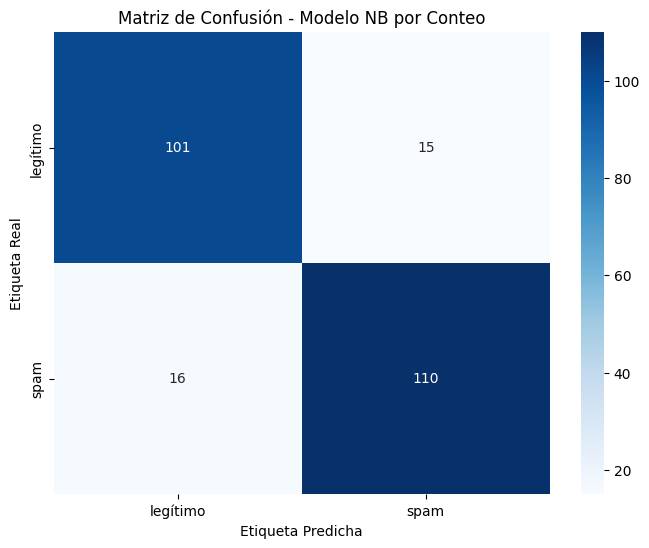

In [31]:
# Calcula y muestra la matriz de confusión para el modelo NB por conteo
confusion_mat_count_full = confusion_matrix(test_df['tipo'], y_test_pred_count_full)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_count_full.T, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf_count_full.classes_,
            yticklabels=clf_count_full.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Modelo NB por Conteo')
plt.show()

In [32]:
# Muestra el resto de métricas de evaluación para el modelo NB por conteo
print("Métricas de evaluación para el modelo NB por conteo:")
print(classification_report(test_df['tipo'], y_test_pred_count_full, target_names=clf_count_full.classes_, zero_division=0, digits=4))

Métricas de evaluación para el modelo NB por conteo:
              precision    recall  f1-score   support

    legítimo     0.8707    0.8632    0.8670       117
        spam     0.8730    0.8800    0.8765       125

    accuracy                         0.8719       242
   macro avg     0.8719    0.8716    0.8717       242
weighted avg     0.8719    0.8719    0.8719       242



como podemos observar, este informe no nos muestra la min-average :-(

A continuación una forma de calcular todas las ponderaciones ...

In [33]:
# Cálculo de precisión, recall y F1-score con diferentes promedios.
precision_count_full_macro = precision_score(test_df['tipo'], y_test_pred_count_full, average='macro', zero_division=0)
recall_count_full_macro = recall_score(test_df['tipo'], y_test_pred_count_full, average='macro', zero_division=0)
f1_count_full_macro = f1_score(test_df['tipo'], y_test_pred_count_full, average='macro', zero_division=0)
print(f"Macro Average - Precision: {precision_count_full_macro}, Recall: {recall_count_full_macro}, F1-score: {f1_count_full_macro}")

precision_count_full_micro = precision_score(test_df['tipo'], y_test_pred_count_full, average='micro', zero_division=0)
recall_count_full_micro = recall_score(test_df['tipo'], y_test_pred_count_full, average='micro', zero_division=0)
f1_count_full_micro = f1_score(test_df['tipo'], y_test_pred_count_full, average='micro', zero_division=0)
print(f"Micro Average - Precision: {precision_count_full_micro}, Recall: {recall_count_full_micro}, F1-score: {f1_count_full_micro}")

precision_count_full_weighted = precision_score(test_df['tipo'], y_test_pred_count_full, average='weighted', zero_division=0)
recall_count_full_weighted = recall_score(test_df['tipo'], y_test_pred_count_full, average='weighted', zero_division=0)
f1_count_full_weighted = f1_score(test_df['tipo'], y_test_pred_count_full, average='weighted', zero_division=0)
print(f"Weighted Average - Precision: {precision_count_full_weighted}, Recall: {recall_count_full_weighted}, F1-score: {f1_count_full_weighted}")

Macro Average - Precision: 0.8718527640941434, Recall: 0.8716239316239316, F1-score: 0.8717234068019766
Micro Average - Precision: 0.871900826446281, Recall: 0.871900826446281, F1-score: 0.871900826446281
Weighted Average - Precision: 0.8718912139758535, Recall: 0.871900826446281, F1-score: 0.8718811131524694


... es interesante poder determinar qué documentos han fallado.

In [34]:
# Muestra los doucmentos mal clasificados por el modelo NB por conteo
misclassified_count_full = test_df[test_df['tipo'] != y_test_pred_count_full]
print("Documentos mal clasificados por el modelo NB por conteo:")
display(misclassified_count_full)

Documentos mal clasificados por el modelo NB por conteo:


,mensaje,tipo
605,Reconfirma tu correo para evitar suspensiones,spam
12,Felicidades has ganado un telefono nuevo,spam
569,Prueba suerte en la lotería con este número,spam
929,Cambia una vida apadrinando un niño,legítimo
1154,Comienza tu dia con pensamientos positivos,spam
1074,Brinda esperanza apadrinando un nino,legítimo
909,Tu compra está protegida,legítimo
49,Estoy en problemas por favor enviame dinero,legítimo
26,Unete a nuestro club de descuentos,legítimo
629,Multiplica tus ganancias integrándote a nuestr...,spam


### 7.4.2 Matriz de Conusión y Métricas específicas para el Modelo NB por TF-IDF

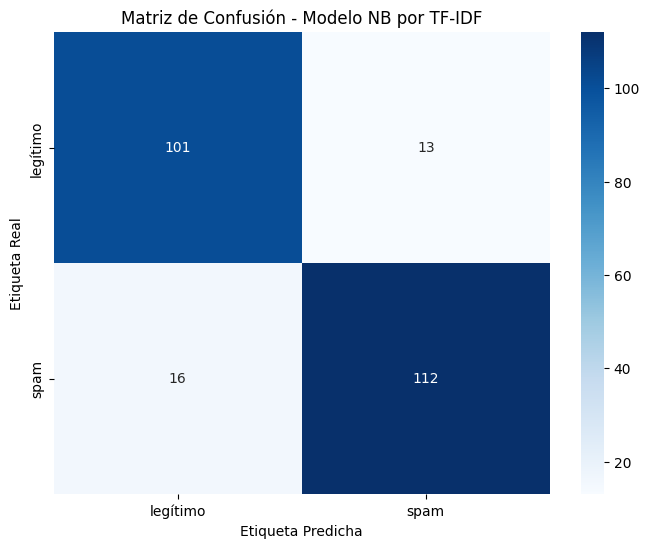

In [35]:
# Calcula y muestra la matriz de confusión para el modelo NB por TF-IDF
confusion_mat_count_full = confusion_matrix(test_df['tipo'], y_test_pred_tfidf_full)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_count_full.T, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf_count_full.classes_,
            yticklabels=clf_count_full.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Modelo NB por TF-IDF')
plt.show()

In [36]:
# Muestra el reporte de clasificación para el modelo NB por TF-IDF
print("Métricas de evaluación para el modelo NB por TF-IDF:")
print(classification_report(test_df['tipo'], y_test_pred_tfidf_full))

Métricas de evaluación para el modelo NB por TF-IDF:
              precision    recall  f1-score   support

    legítimo       0.89      0.86      0.87       117
        spam       0.88      0.90      0.89       125

    accuracy                           0.88       242
   macro avg       0.88      0.88      0.88       242
weighted avg       0.88      0.88      0.88       242



In [37]:
# Cálculo de precisión, recall y F1-score con diferentes promedios.
precision_count_full_macro = precision_score(test_df['tipo'], y_test_pred_tfidf_full, average='macro', zero_division=0)
recall_count_full_macro = recall_score(test_df['tipo'], y_test_pred_tfidf_full, average='macro', zero_division=0)
f1_count_full_macro = f1_score(test_df['tipo'], y_test_pred_tfidf_full, average='macro', zero_division=0)
print(f"Macro Average - Precision: {precision_count_full_macro}, Recall: {recall_count_full_macro}, F1-score: {f1_count_full_macro}")

precision_count_full_micro = precision_score(test_df['tipo'], y_test_pred_tfidf_full, average='micro', zero_division=0)
recall_count_full_micro = recall_score(test_df['tipo'], y_test_pred_tfidf_full, average='micro', zero_division=0)
f1_count_full_micro = f1_score(test_df['tipo'], y_test_pred_tfidf_full, average='micro', zero_division=0)
print(f"Micro Average - Precision: {precision_count_full_micro}, Recall: {recall_count_full_micro}, F1-score: {f1_count_full_micro}")

precision_count_full_weighted = precision_score(test_df['tipo'], y_test_pred_tfidf_full, average='weighted', zero_division=0)
recall_count_full_weighted = recall_score(test_df['tipo'], y_test_pred_tfidf_full, average='weighted', zero_division=0)
f1_count_full_weighted = f1_score(test_df['tipo'], y_test_pred_tfidf_full, average='weighted', zero_division=0)
print(f"Weighted Average - Precision: {precision_count_full_weighted}, Recall: {recall_count_full_weighted}, F1-score: {f1_count_full_weighted}")

Macro Average - Precision: 0.8804824561403508, Recall: 0.8796239316239316, F1-score: 0.8799171842650104
Micro Average - Precision: 0.8801652892561983, Recall: 0.8801652892561983, F1-score: 0.8801652892561983
Weighted Average - Precision: 0.8803012179208352, Recall: 0.8801652892561983, F1-score: 0.8800976242586016


In [38]:
# Muestra los doucmentos mal clasificados por el modelo NB por TF-IDF
misclassified_tfidf_full = test_df[test_df['tipo'] != y_test_pred_tfidf_full]
print("Documentos mal clasificados por el modelo NB por TF-IDF:")
display(misclassified_tfidf_full)

Documentos mal clasificados por el modelo NB por TF-IDF:


,mensaje,tipo
605,Reconfirma tu correo para evitar suspensiones,spam
12,Felicidades has ganado un telefono nuevo,spam
569,Prueba suerte en la lotería con este número,spam
929,Cambia una vida apadrinando un niño,legítimo
1154,Comienza tu dia con pensamientos positivos,spam
1074,Brinda esperanza apadrinando un nino,legítimo
909,Tu compra está protegida,legítimo
49,Estoy en problemas por favor enviame dinero,legítimo
26,Unete a nuestro club de descuentos,legítimo
1170,Apoya esta causa solidaria con tu aporte,spam
